<a href="https://colab.research.google.com/github/ShankarChavan/synthetic-data-generation/blob/main/SDV/GaussianCoupla/GaussianCoupla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SDV (Synthetic Data Vault)

The **Synthetic Data Vault** (SDV) is a Python library designed to be your one-stop shop for creating tabular synthetic data

# Download and Install SDV

In [ ]:
# Install required libraries
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install sdv
!pip install ydata-profiling

In [2]:
import sdv

print(sdv.version.public)

1.10.0


# Loading the demo data

In [3]:
from sdv.datasets.demo import download_demo

real_data, metadata = download_demo(
    modality='single_table',
    dataset_name='fake_hotel_guests'
)

**Details**: The data is available as a single table.
- `guest_email` is a _primary key_ that uniquely identifies every row
- Other columns have a variety of data types and some the data may be missing.

In [4]:
real_data.head()

,guest_email,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,michaelsanders@shaw.net,False,BASIC,37.89,27 Dec 2020,29 Dec 2020,131.23,"49380 Rivers Street\nSpencerville, AK 68265",4075084747483975747
1,randy49@brown.biz,False,BASIC,24.37,30 Dec 2020,02 Jan 2021,114.43,"88394 Boyle Meadows\nConleyberg, TN 22063",180072822063468
2,webermelissa@neal.com,True,DELUXE,0.00,17 Sep 2020,18 Sep 2020,368.33,"0323 Lisa Station Apt. 208\nPort Thomas, LA 82585",38983476971380
3,gsims@terry.com,False,BASIC,NaN,28 Dec 2020,31 Dec 2020,115.61,"77 Massachusetts Ave\nCambridge, MA 02139",4969551998845740
4,misty33@smith.biz,False,BASIC,16.45,05 Apr 2020,NaN,122.41,"1234 Corporate Drive\nBoston, MA 02116",3558512986488983


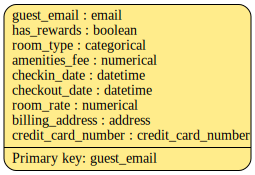

In [5]:
metadata.visualize()

**Auto Detect Metadata** :
Automatically detect the metadata based on your actual data.

In [6]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()

In [7]:
metadata.detect_from_dataframe(real_data)

In [8]:
metadata

{
    "columns": {
        "guest_email": {
            "sdtype": "email",
            "pii": true
        },
        "has_rewards": {
            "sdtype": "categorical"
        },
        "room_type": {
            "sdtype": "categorical"
        },
        "amenities_fee": {
            "sdtype": "numerical"
        },
        "checkin_date": {
            "sdtype": "datetime",
            "datetime_format": "%d %b %Y"
        },
        "checkout_date": {
            "sdtype": "datetime",
            "datetime_format": "%d %b %Y"
        },
        "room_rate": {
            "sdtype": "numerical"
        },
        "billing_address": {
            "sdtype": "unknown",
            "pii": true
        },
        "credit_card_number": {
            "sdtype": "credit_card_number",
            "pii": true
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "primary_key": "guest_email"
}

# Single Table Data


## Gaussian Coupla

We'll use the Gaussian Copula algorithm to do this. Gaussian Copula is a fast, customizable and transparent way to synthesize data.

### Creating a Synthesizer

In [9]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(real_data)

/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:79: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Other Parameters that can we used and is not manadatory

In [10]:
synthesizer.get_parameters()

{'enforce_min_max_values': True,
 'enforce_rounding': True,
 'locales': None,
 'numerical_distributions': {},
 'default_distribution': 'beta'}

**Generate synthetic data** : Use the sample function and pass in any number of rows to synthesize.

In [11]:
synthetic_data = synthesizer.sample(num_rows=500)
synthetic_data.head()

,guest_email,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,dsullivan@example.net,True,BASIC,2.34,26 Mar 2020,11 Apr 2020,119.53,sdv-pii-q0g03,5161033759518983
1,steven59@example.org,False,DELUXE,NaN,02 Jul 2020,14 Sep 2020,174.70,sdv-pii-hr6mb,4133047413145475690
2,brandon15@example.net,False,BASIC,22.08,30 Mar 2020,17 Mar 2020,148.34,sdv-pii-vy4n9,4977328103788
3,humphreyjennifer@example.net,False,BASIC,8.18,03 May 2020,22 May 2020,177.51,sdv-pii-4xdjt,3524946844839485
4,joshuabrown@example.net,False,SUITE,7.69,13 Jan 2020,10 Jan 2020,187.93,sdv-pii-p73w1,4446905799576890978


### Evaluating Real vs. Synthetic Data

SDV has built-in functions for evaluating the synthetic data and getting more insight.

As a first step, we can run a **diagnostic** to ensure that the data is valid. SDV's diagnostic performs some basic checks such as:

- All primary keys must be unique
- Continuous values must adhere to the min/max of the real data
- Discrete columns (non-PII) must have the same categories as the real data
- Etc.



In [12]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 136.74it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%


<font color="green"><b>The score is 100%</b></font>, indicating that the data is fully valid.

We can also measure the **data quality** or the statistical similarity between the real and synthetic data. This value may vary anywhere from 0 to 100%.

In [13]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 36/36 [00:00<00:00, 115.57it/s]

Overall Score: 88.7%

Properties:
- Column Shapes: 89.11%
- Column Pair Trends: 88.3%


In [14]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,has_rewards,TVComplement,0.986000
1,room_type,TVComplement,0.968000
2,amenities_fee,KSComplement,0.717449
3,checkin_date,KSComplement,0.970000
4,checkout_date,KSComplement,0.975000
5,room_rate,KSComplement,0.730000


### Visualising Data
Let's perform a 1D visualization comparing a column of the real data to the synthetic data.

In [15]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name='amenities_fee',
    metadata=metadata
)

fig.show()

We can also visualize in 2D, comparing the correlations of a pair of columns.

In [16]:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_names=['room_rate', 'room_type'],
    metadata=metadata
)

fig.show()

# Customize Copula
A key benefit of using the Gaussian Copula is customization and transparency. This synthesizer estimates the shape of every column using a 1D distribution. We can set these shapes ourselves.

In [17]:
custom_synthesizer = GaussianCopulaSynthesizer(
    metadata,
    default_distribution='truncnorm',
    numerical_distributions={
        'checkin_date': 'uniform',
        'checkout_date': 'uniform',
        'room_rate': 'gaussian_kde'
    }
)

custom_synthesizer.fit(real_data)

After training, we can inspect the distributions. In this case, the synthesizer returns the parameter it learned using the truncnorm distribution.

<font color=navy><i>More information about truncnorm distribution is available in the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html).</i></font>

In [18]:
learned_distributions = custom_synthesizer.get_learned_distributions()
learned_distributions['has_rewards']

{'distribution': 'truncnorm',
 'learned_parameters': {'a': -0.5248941600815897,
  'b': 0.47865112393557874,
  'loc': 0.5224378986937426,
  'scale': 0.9929469625853422}}

## Generate data from Customize GaussianCopula Model

In [21]:
synthetic_data_customized = custom_synthesizer.sample(num_rows=500)
synthetic_data_customized.head()

,guest_email,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,dsullivan@example.net,False,BASIC,9.64,2020-03-13,2020-03-31,124.68,sdv-pii-q0g03,5161033759518983
1,steven59@example.org,False,DELUXE,NaN,2020-06-19,2020-09-01,165.08,sdv-pii-hr6mb,4133047413145475690
2,brandon15@example.net,False,BASIC,23.53,2020-03-20,2020-03-12,136.69,sdv-pii-vy4n9,4977328103788
3,humphreyjennifer@example.net,False,BASIC,17.74,2020-04-23,2020-05-12,177.80,sdv-pii-4xdjt,3524946844839485
4,joshuabrown@example.net,False,DELUXE,16.20,2020-01-10,2020-01-09,172.85,sdv-pii-p73w1,4446905799576890978


## Evaluate generated data

In [22]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data_customized,
    metadata=metadata
)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 105.82it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%


In [23]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 36/36 [00:00<00:00, 108.37it/s]

Overall Score: 88.7%

Properties:
- Column Shapes: 89.11%
- Column Pair Trends: 88.3%


Following are Quality metric used for comparison between real vs synthetic data

[KScomplement(Kolmogorov-Smirnov statistic)](https://docs.sdv.dev/sdmetrics/metrics/metrics-glossary/kscomplement)

**Numerical** : This metric is meant for continuous, numerical data

**Datetime** : This metric converts datetime values into numerical values

[TVComplement(Total Variation Distance)](https://docs.sdv.dev/sdmetrics/metrics/metrics-glossary/tvcomplement)

**Categorical**: This metric is meant for discrete, categorical data

**Boolean**: This metric works well on boolean data

In [24]:
quality_report.get_visualization("Column Shapes")

In [25]:
quality_report.get_visualization("Column Pair Trends")

## Generate Comparison report of real vs synthetic data

In [26]:

from ydata_profiling import ProfileReport

#data = pd.read_csv("train.csv")
real_data_report = ProfileReport(real_data.iloc[:500], title="original_data")

#test_df = pd.read_csv("test.csv")
synthetic_data_report = ProfileReport(synthetic_data_customized, title="synthetic_data")

comparison_report = real_data_report.compare(synthetic_data_report)
comparison_report.to_file("comparison_Coupula.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:354: UserWarning:

Try running command: 'pip install --upgrade Pillow' to avoid ValueError



Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
comparison_report

**Save and Load**

In [19]:
synthesizer.save('GaussianCopulaSynthesizer.pkl')

synthesizer = GaussianCopulaSynthesizer.load('GaussianCopulaSynthesizer.pkl')